# Задача: Отобразить высокомерные данные $X ∈ ℝ^D$ в низкомерное пространство $Y ∈ ℝ^d (d=2,3)$ так, чтобы сохранить структуру соседства.

    1. Вероятностная постановка задачи


Задача: Отобразить высокомерные данные $X ∈ ℝ^D$ в низкомерное пространство $Y ∈ ℝ^d (d=2,3)$
так, чтобы сохранить структуру соседства.


        - Вероятности в исходном пространстве

Гауссово ядро для измерения сходства:

$
p_{j|i} = exp(-||x_i - x_j||^2 / (2σ_i^2)) / Σ_{k≠i} exp(-||x_i - x_k||^2 / (2σ_i^2))$

Симметризация вероятностей:

$
p_{ij} = (p_{j|i} + p_{i|j}) / (2n)$

Перплексия (perplexity) как гиперпараметр:

$
Perp(P_i) = 2^{H(P_i)}, $

где $H(P_i) = -Σ_j p_{j|i} log₂ p_{j|i}$

        - Вероятности в целевом пространстве

Распределение Стьюдента с одной степенью свободы:

$
q_{ij} = (1 + ||y_i - y_j||^2)^{-1} / Σ_{k≠l} (1 + ||y_k - y_l||^2)^{-1}$

Преимущества t-распределения:

       * Тяжелые хвосты

       * Устойчивость к проклятию размерности

       * Улучшенное разделение кластеров

       * Функция стоимости (KL-дивергенция)

$C(Y) = KL(P||Q) = Σ_i Σ_j p_{ij} log(p_{ij} / q_{ij})$

    2. Оптимизация функции стоимости

        2.1. Градиент функции стоимости

$∂C/∂y_i = 4 Σ_j (p_{ij} - q_{ij})(y_i - y_j)(1 + ||y_i - y_j||^2)^{-1}$

       2.2. Методы оптимизации

Градиентный спуск с моментумом:

$Y^{(t)} = Y^{(t-1)} + η ∂C/∂Y + α(t)(Y^{(t-1)} - Y^{(t-2)})$


Раннее преувеличение (early exaggeration):


$p_{ij} ← p_{ij} × 4 (первые 100 итераций)$


Адаптивное обучение (adaptive learning rate)

        2.3. Сложности оптимизации

            - Невыпуклость функции стоимости

            - Локальные минимумы

            - Чувствительность к начальной инициализации

            - Вычислительная сложность O(n²)

Импорт библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


# Задание

1. Провести исследование влияния гиперпараметров на результаты кластеризации с T-SNE
2. Сравнить с PCA
   
Использовать 2 датасета - стандартного типа Ирис или Цифры, и своего. Не забываем про нормировку и eda в целом

In [2]:
df = pd.read_csv('data.csv')
df

Temperature  Humidity  PM2.5   PM10   NO2   SO2    CO  \
0            29.8      59.1    5.2   17.9  18.9   9.2  1.72   
1            28.3      75.6    2.3   12.2  30.8   9.7  1.64   
2            23.1      74.7   26.7   33.8  24.4  12.6  1.63   
3            27.1      39.1    6.1    6.3  13.5   5.3  1.15   
4            26.5      70.7    6.9   16.0  21.9   5.6  1.01   
...           ...       ...    ...    ...   ...   ...   ...   
4995         40.6      74.1  116.0  126.7  45.5  25.7  2.11   
4996         28.1      96.9    6.9   25.0  25.3  10.8  1.54   
4997         25.9      78.2   14.2   22.1  34.8   7.8  1.63   
4998         25.3      44.4   21.4   29.0  23.7   5.7  0.89   
4999         24.1      77.9   81.7   94.3  23.2  10.5  1.38   

      Proximity_to_Industrial_Areas  Population_Density Air Quality  
0                               6.3                 319    Moderate  
1                               6.0                 611    Moderate  
2                               5.2                 619    Moderate  
3                              11.1                 551        Good  
4                              12.7                 303        Good  
...                             ...                 ...         ...  
4995                            2.8                 765   Hazardous  
4996                            5.7                 709    Moderate  
4997                            9.6                 379    Moderate  
4998                           11.6                 241        Good  
4999                            8.3                 461    Moderate  

[5000 rows x 10 columns]

In [3]:
label_mapping = {
    "Good": 0,
    "Moderate": 1,
    "Poor": 2,
    "Hazardous": 3
}

label_names = {
    0: "Good",
    1: "Moderate",
    2: "Poor",
    3: "Hazardous"
}

df['Air Quality'] = df['Air Quality'].map(label_mapping)

In [4]:
df

Temperature  Humidity  PM2.5   PM10   NO2   SO2    CO  \
0            29.8      59.1    5.2   17.9  18.9   9.2  1.72   
1            28.3      75.6    2.3   12.2  30.8   9.7  1.64   
2            23.1      74.7   26.7   33.8  24.4  12.6  1.63   
3            27.1      39.1    6.1    6.3  13.5   5.3  1.15   
4            26.5      70.7    6.9   16.0  21.9   5.6  1.01   
...           ...       ...    ...    ...   ...   ...   ...   
4995         40.6      74.1  116.0  126.7  45.5  25.7  2.11   
4996         28.1      96.9    6.9   25.0  25.3  10.8  1.54   
4997         25.9      78.2   14.2   22.1  34.8   7.8  1.63   
4998         25.3      44.4   21.4   29.0  23.7   5.7  0.89   
4999         24.1      77.9   81.7   94.3  23.2  10.5  1.38   

      Proximity_to_Industrial_Areas  Population_Density  Air Quality  
0                               6.3                 319            1  
1                               6.0                 611            1  
2                               5.2                 619            1  
3                              11.1                 551            0  
4                              12.7                 303            0  
...                             ...                 ...          ...  
4995                            2.8                 765            3  
4996                            5.7                 709            1  
4997                            9.6                 379            1  
4998                           11.6                 241            0  
4999                            8.3                 461            1  

[5000 rows x 10 columns]

In [5]:
from sklearn.datasets import load_digits

# 1. Загрузка данных
digits = load_digits()
X = digits.data
y = digits.target

Разделить выборку на фичи и целевую переменную

In [6]:
feature_cols = 'Air Quality'
my_X = df.drop(feature_cols, axis=1)
my_y = df[feature_cols]

print(my_X.shape, my_y.shape)


(5000, 9) (5000,)


Нормировка

In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
my_X_scaled = scaler.fit_transform(my_X)

pca = PCA(n_components=2, random_state=42)

Доля объяснённой дисперсии: [0.12033916 0.09561054] Суммарно: 0.21594970500832786


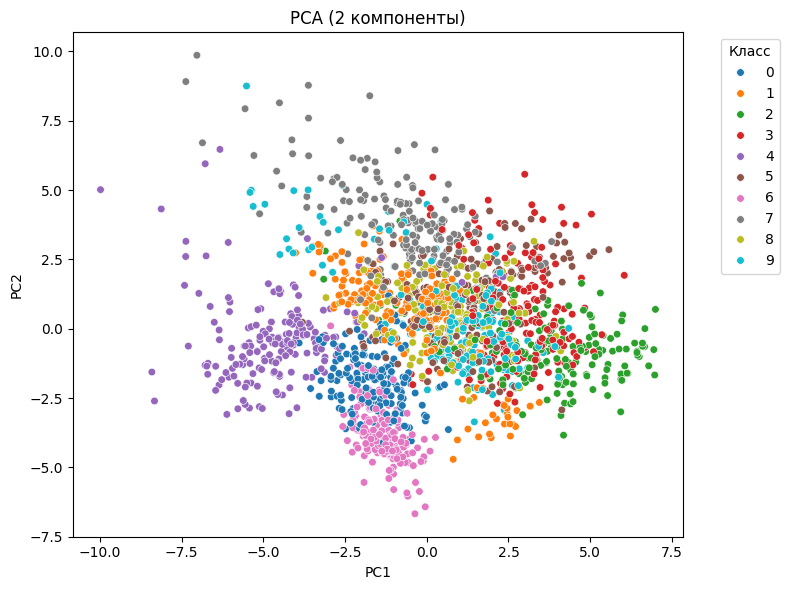

In [20]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print("Доля объяснённой дисперсии:",   pca.explained_variance_ratio_,
      "Суммарно:",  pca.explained_variance_ratio_.sum())

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette="tab10", s=30)
plt.title("PCA (2 компоненты)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Класс", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


Доля объяснённой дисперсии: [0.55721851 0.14969909] Суммарно: 0.7069175963944492


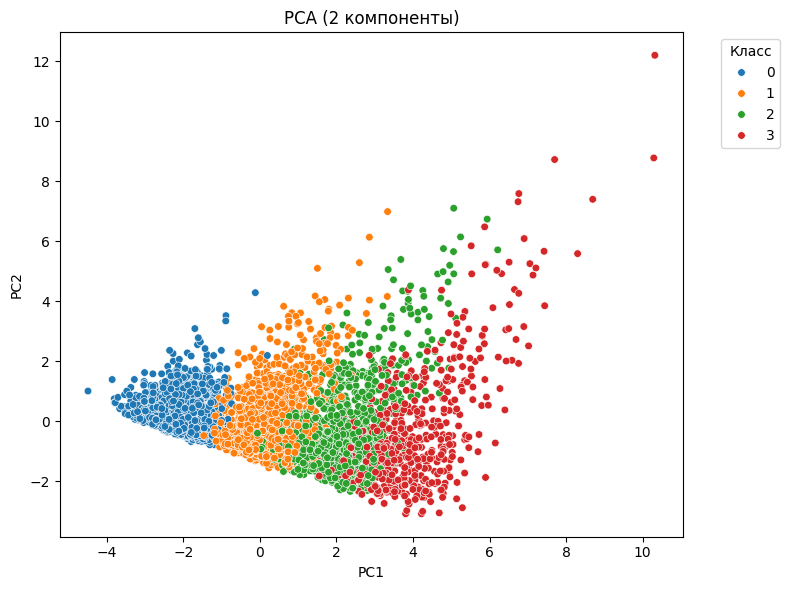

In [27]:
pca = PCA(n_components=2, random_state=42)
my_X_pca = pca.fit_transform(my_X_scaled)

print("Доля объяснённой дисперсии:",   pca.explained_variance_ratio_,
      "Суммарно:",  pca.explained_variance_ratio_.sum())

plt.figure(figsize=(8, 6))
sns.scatterplot(x=my_X_pca[:, 0], y=my_X_pca[:, 1], hue=my_y, palette="tab10", s=30)
plt.title("PCA (2 компоненты)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Класс", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


TSNE 2 компоненты

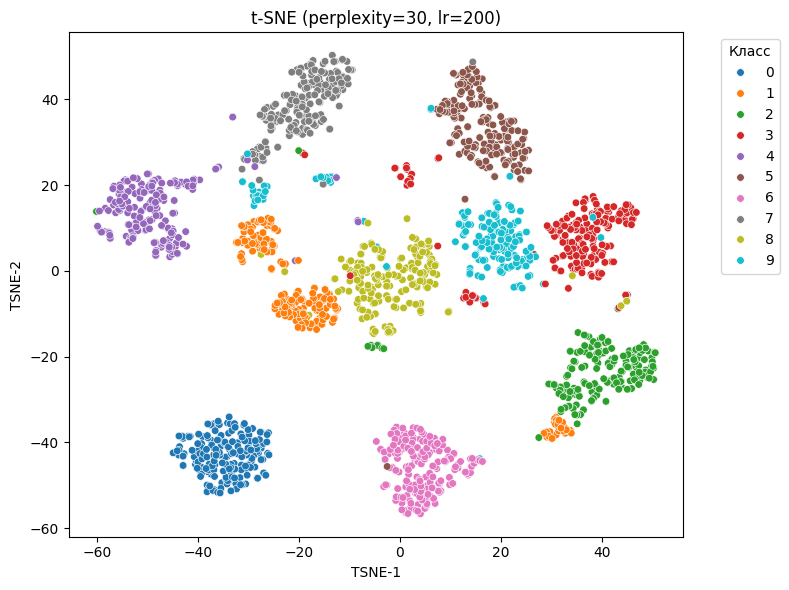

In [30]:
tsne = TSNE(
    n_components=2,
    random_state=42,
    learning_rate=200
)

X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, palette="tab10", s=30)
plt.title("t-SNE (perplexity=30, lr=200)")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.legend(title="Класс", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


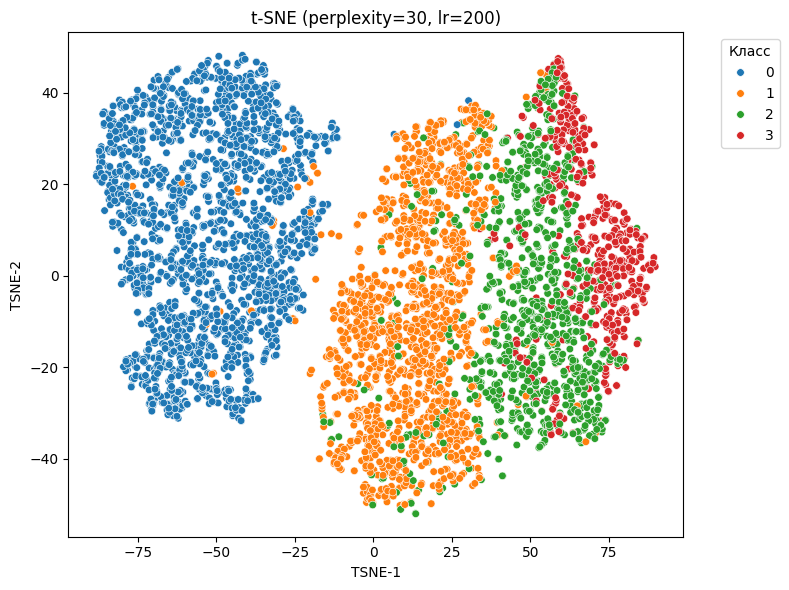

In [32]:
tsne = TSNE(
    n_components=2,
    random_state=42,
    learning_rate=200
)

my_X_tsne = tsne.fit_transform(my_X_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=my_X_tsne[:, 0], y=my_X_tsne[:, 1], hue=my_y, palette="tab10", s=30)
plt.title("t-SNE (perplexity=30, lr=200)")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.legend(title="Класс", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [35]:
from sklearn.metrics import pairwise_distances

def separation_score(X_2d, y):
    D = pairwise_distances(X_2d)
    same = D[y[:, None] == y[None, :]]
    diff = D[y[:, None] != y[None, :]]
    return same.mean(), diff.mean(), diff.mean() / same.mean()

pca_same, pca_diff, pca_ratio = separation_score(X_pca, y)
tsne_same, tsne_diff, tsne_ratio = separation_score(X_tsne, y)

print("PCA:  среднее расстояние внутри класса =", pca_same,
      ", между классами =", pca_diff,
      ", ratio =", pca_ratio)
print("t-SNE: среднее расстояние внутри класса =", tsne_same,
      ", между классами =", tsne_diff,
      ", ratio =", tsne_ratio)


PCA:  среднее расстояние внутри класса = 2.468234399163823 , между классами = 4.761456156687808 , ratio = 1.9290939945982732
t-SNE: среднее расстояние внутри класса = 13.999029 , между классами = 55.66477 , ratio = 3.9763305


In [40]:
my_pca_same, my_pca_diff, my_pca_ratio = separation_score(my_X_pca, np.array(my_y))
my_tsne_same, my_tsne_diff, my_tsne_ratio = separation_score(my_X_tsne, np.array(my_y))

print("PCA:  среднее расстояние внутри класса =", my_pca_same,
      ", между классами =", my_pca_diff,
      ", ratio =", my_pca_ratio)
print("t-SNE: среднее расстояние внутри класса =", my_tsne_same,
      ", между классами =", my_tsne_diff,
      ", ratio =", my_tsne_ratio)


PCA:  среднее расстояние внутри класса = 1.2730163393726979 , между классами = 3.684294228886645 , ratio = 2.89414527915812
t-SNE: среднее расстояние внутри класса = 34.55777 , между классами = 81.14433 , ratio = 2.3480778


Вычислить и отрисовать T-SNE с разным значением Perplexity

In [46]:
perplexities = [5, 30, 50, 100]
learning_rates = [50, 200, 1000, 1500]

In [ ]:
fig, axes = plt.subplots(len(perplexities), len(learning_rates),
                         figsize=(5*len(learning_rates), 4*len(perplexities)))

for i, perp in enumerate(perplexities):
    for j, lr in enumerate(learning_rates):
        tsne = TSNE(
            perplexity=perp,
            learning_rate=lr,
            random_state=42
        )
        X_emb = tsne.fit_transform(X_scaled)
        ax = axes[i, j]
        sns.scatterplot(x=X_emb[:, 0], y=X_emb[:, 1],
                        hue=y, palette="tab10", s=10, ax=ax, legend=False)
        ax.set_title(f"perp={perp}, lr={lr}")
        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout()
plt.show()


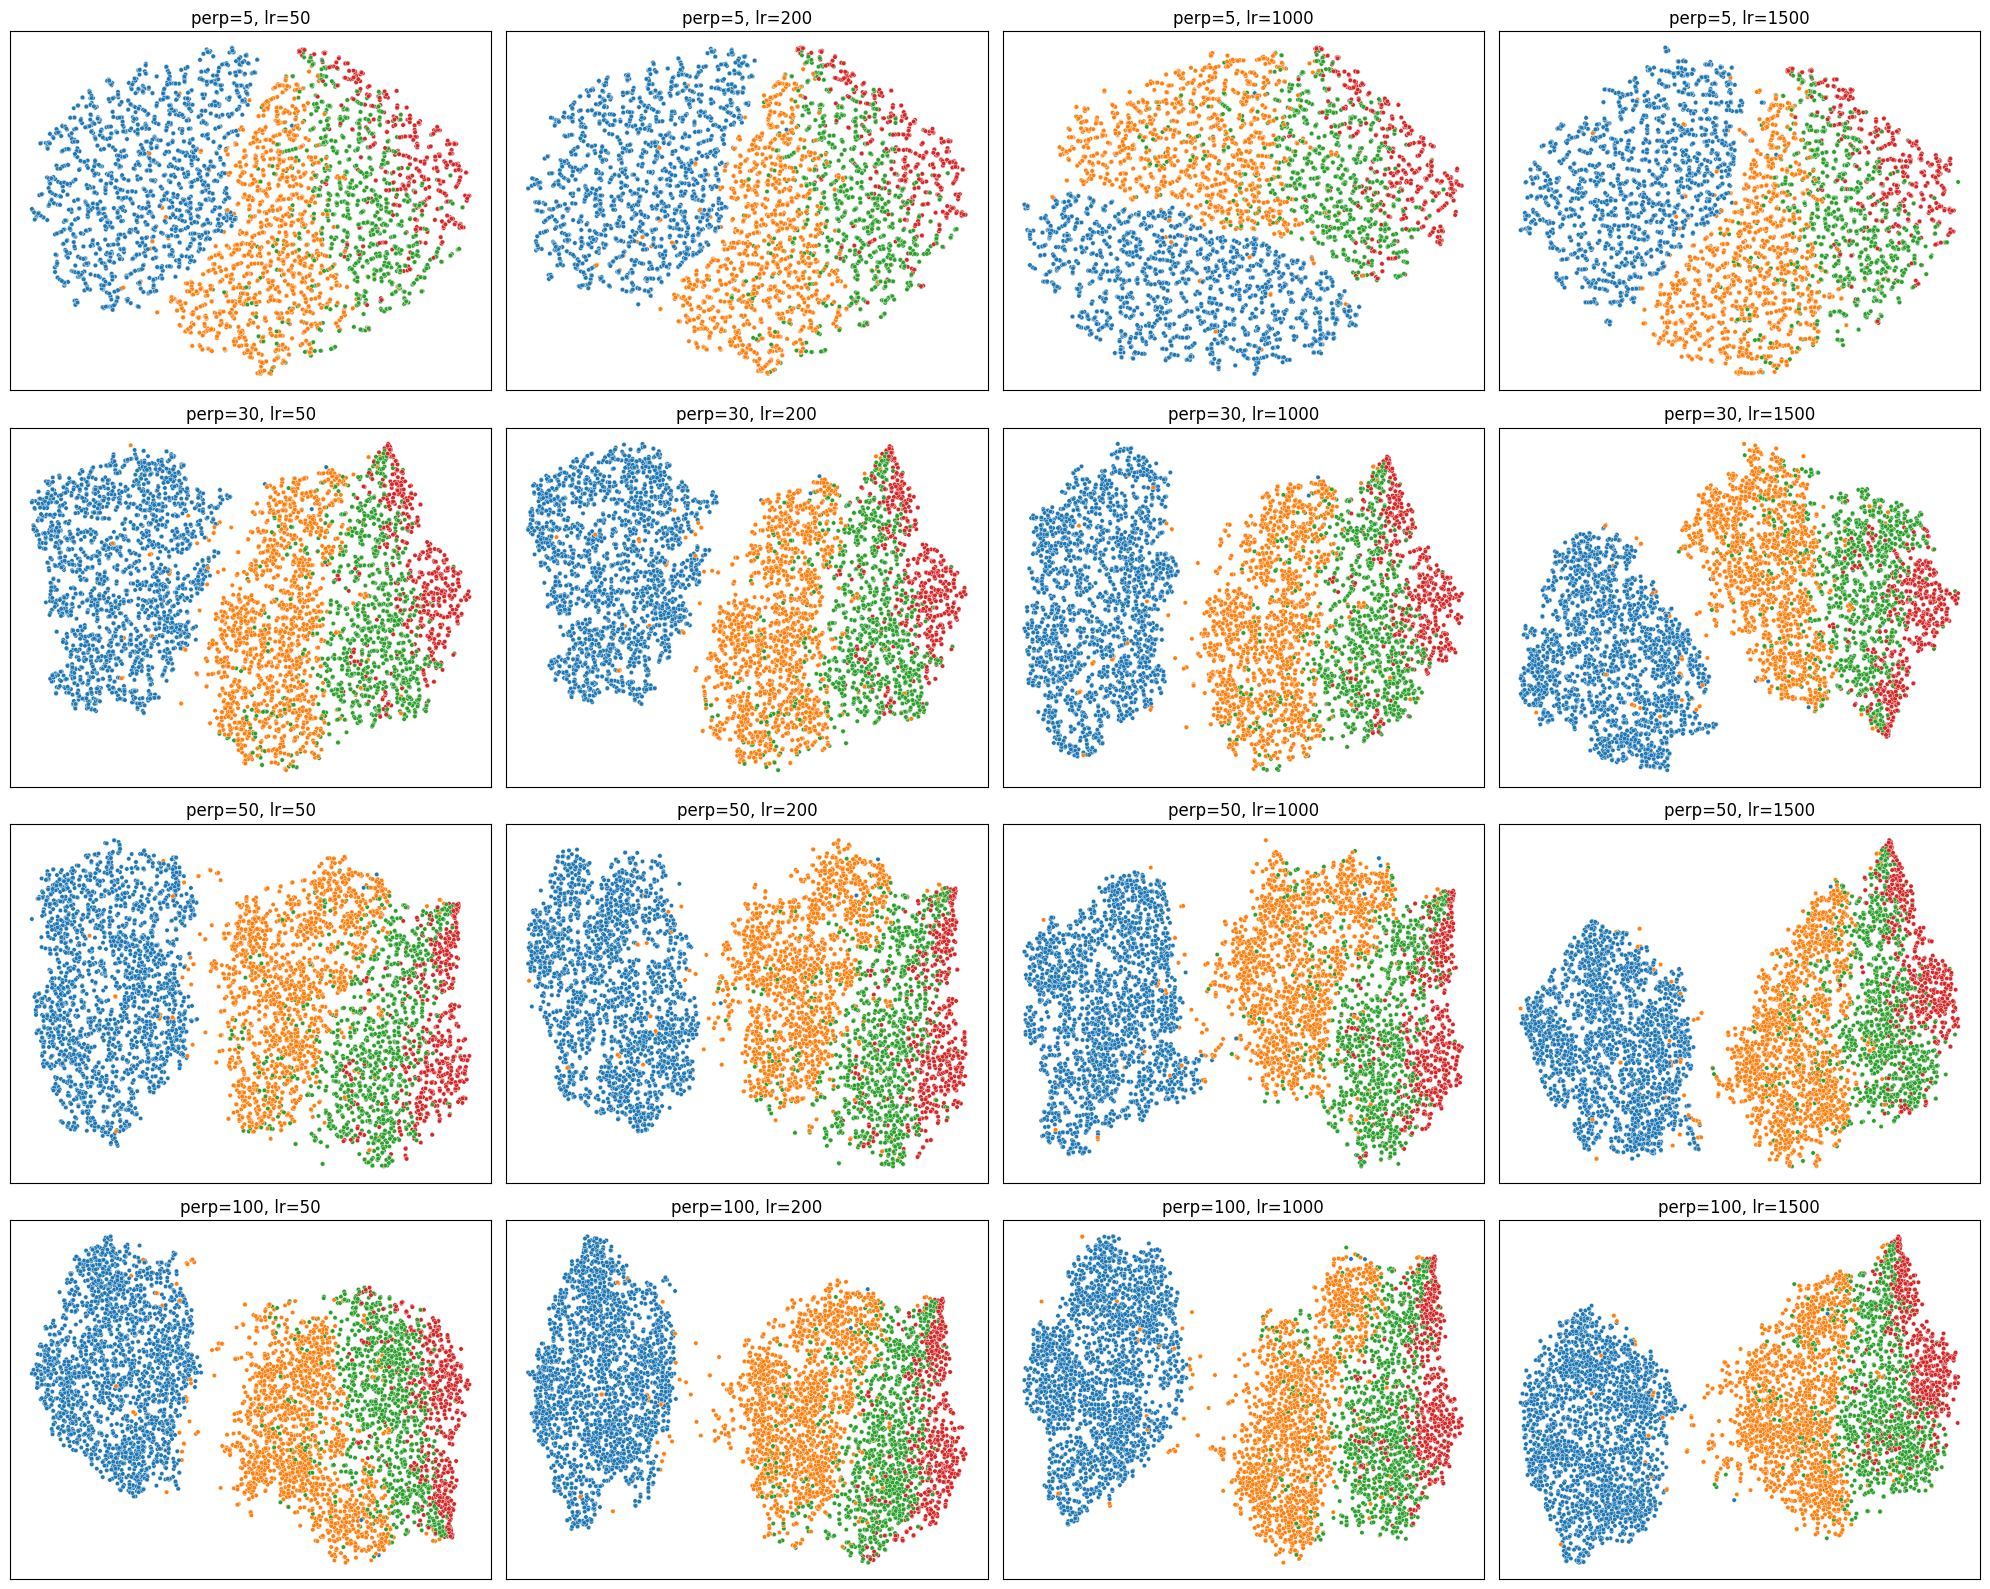

In [47]:
fig, axes = plt.subplots(len(perplexities), len(learning_rates),
                         figsize=(5*len(learning_rates), 4*len(perplexities)))

for i, perp in enumerate(perplexities):
    for j, lr in enumerate(learning_rates):
        tsne = TSNE(
            perplexity=perp,
            learning_rate=lr,
            random_state=42
        )
        X_emb = tsne.fit_transform(my_X_scaled)
        ax = axes[i, j]
        sns.scatterplot(x=X_emb[:, 0], y=X_emb[:, 1],
                        hue=my_y, palette="tab10", s=10, ax=ax, legend=False)
        ax.set_title(f"perp={perp}, lr={lr}")
        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout()
plt.show()


* При меньших значения perplexity кластеры более разряжены, а learn rate влияет на расстояния между кластерами
* небольшие изменения perplexity влияет средне на рисунок
* небольшие изменения learn rate сильно влияет на рисунок

Проанализируйте:

как меняется форма кластеров,

возникают ли “разрывы” или слияния при разных параметрах,

насколько стабилен рисунок при небольших изменениях параметров.

PCA: устойчивая структура
Для PCA параметров немного (по сути только число компонент), проекция при фиксированном random_state практически не меняется, что показывает устойчивость метода.

Можно показать, что при разных n_components (2, 3, больше) первые две компоненты остаются близкими, а общая структура мало меняется.

In [ ]:
n_components = [2, 3, 4, 5, 10]

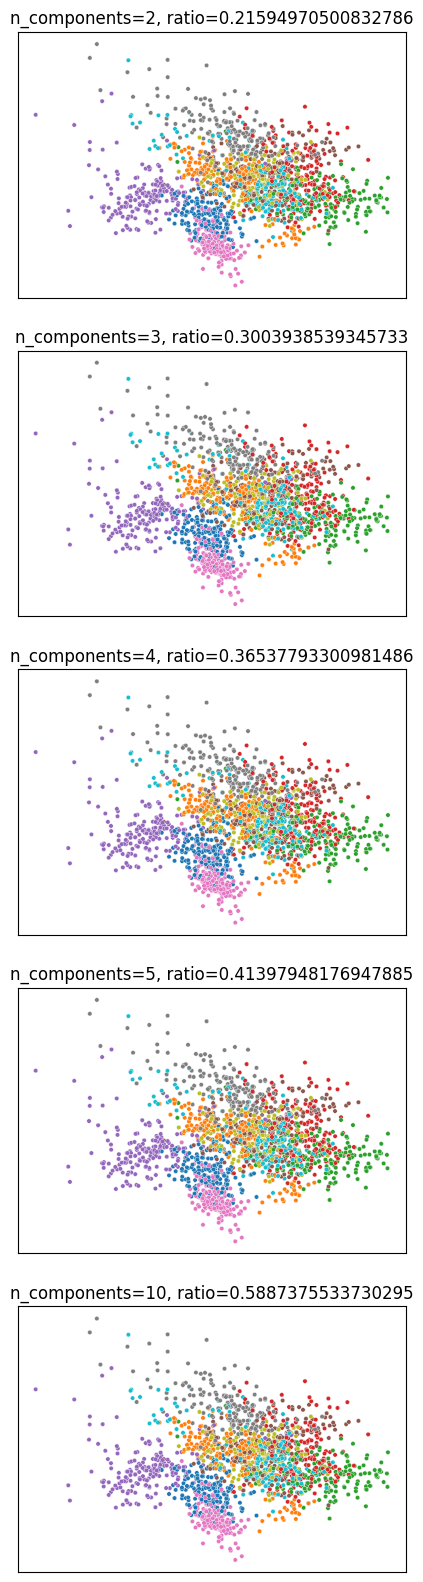

In [68]:
fig, axes = plt.subplots(len(n_components), 1, figsize=(len(n_components), 4*len(n_components)))

for i, n in enumerate(n_components):
  pca = PCA(n_components=n, random_state=42)
  X_pca = pca.fit_transform(X_scaled)

  ax = axes[i]
  sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1],
                hue=y, palette="tab10", s=10, ax=ax, legend=False)
  ax.set_title(f"n_components={n}, ratio={pca.explained_variance_ratio_.sum()}")
  ax.set_xticks([])
  ax.set_yticks([])

In [70]:
n_components = [2, 3, 4, 5]

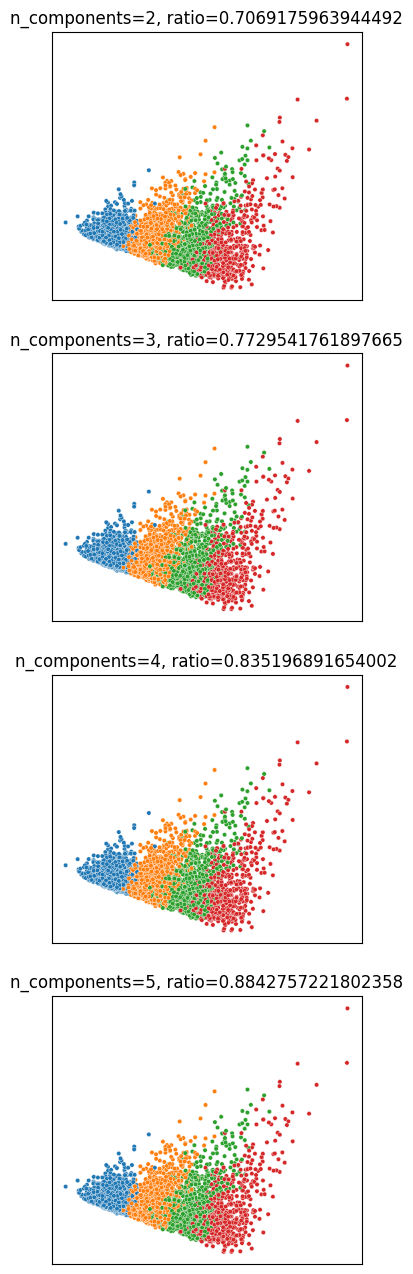

In [71]:
fig, axes = plt.subplots(len(n_components), 1, figsize=(len(n_components), 4*len(n_components)))

for i, n in enumerate(n_components):
  pca = PCA(n_components=n, random_state=42)
  X_pca = pca.fit_transform(my_X_scaled)

  ax = axes[i]
  sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1],
                hue=my_y, palette="tab10", s=10, ax=ax, legend=False)
  ax.set_title(f"n_components={n}, ratio={pca.explained_variance_ratio_.sum()}")
  ax.set_xticks([])
  ax.set_yticks([])
